In [2]:
# general imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Text processing imports
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction import text

In [3]:
# List adapeted from:
# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/

my_stops = text.ENGLISH_STOP_WORDS.union(
    
     ["ourselves", "hers", "between", "yourself", "but", "again",
     "there", "about", "once", "during", "out", "very", "having",
     "with", "they", "own", "an", "be", "some", "for", "do", "its",
     "yours", "such", "into", "of", "most", "itself", "other", "off",
     "is", "s", "am", "or", "who", "as", "from", "him", "each", "the",
     "themselves", "until", "below", "are", "we", "these", "your", "his", 
     "through", "don", "nor", "me", "were", "her", "more", "himself", "this",
     "down", "should", "our", "their", "while", "above", "both", "up", "to", 
     "ours", "had", "she", "all", "no", "when", "at", "any", "before", "them", 
     "same", "and", "been", "have", "in", "will", "on", "does", "yourselves", 
     "then", "that", "because", "what", "over", "why", "so", "can", "did", "not",
     "now", "under", "he", "you", "herself", "has", "just", "where", "too", "only",
     "myself", "which", "those", "i", "after", "few", "whom", "t", "being", "if", "theirs",
     "my", "against", "a", "by", "doing", "it", "how", "further", "was", "here", "than", "coronavirus", "covid"]

)

## Data

Articles from the following links:
http://transcripts.cnn.com/TRANSCRIPTS/2005/04/acd.01.html
http://transcripts.cnn.com/TRANSCRIPTS/2005/05/acd.01.html
https://www.foxnews.com/opinion/gutfeld-on-limiting-coronavirus-lawsuits
https://www.foxnews.com/opinion/gutfeld-trump-media-covid-pandemic


In [4]:
articles = pd.read_csv('sample.csv')
articles.head()

,Unnamed: 0,source,text
0,0,CNN,"According to at least one of those reports, t..."
1,1,CNN,"ANDERSON COOPER, CNN HOST: Erin, thanks very m..."
2,2,Fox,I’m just going to list some lawsuits arising f...
3,3,Fox,At Sunday night’s town hall on Fox News Channe...


In [5]:
vectorizer = CountVectorizer(min_df=3, stop_words=my_stops)
counts = vectorizer.fit_transform(articles.text)

## LDA

In [6]:
as_topics = LatentDirichletAllocation(n_components=3, random_state=0, n_jobs=6).fit(counts)

In [7]:
def print_topics(topics,vectorizer):
    """
    Prints top 12 most important words for each topic in descending importance
    """
    topic_dists = (topics.components_.T / topics.components_.sum(axis=1)).T
    for comp in range(len(topic_dists)):
        top_i = np.argsort(topic_dists[comp])[-12:][::-1]
        print()
        print([key for key, value in vectorizer.vocabulary_.items() if value in top_i])

In [8]:
print_topics(as_topics, vectorizer)


['post', 'rising', 'need', 'think', 'maybe', 'starting', 'means', 'didn', 'hospitals', 'safety', 'leave', 'hand']

['going', 'like', 'president', 'said', 'got', 'know', 'time', 'day', 'right', 'think', 'mean', 'pandemic']

['like', 'trump', 'question', 'worse', 'run', 'appreciate', 'sure', 'agree', 'sunday', 'hall', 'fox', 'press']


In [9]:
article_dists = as_topics.transform(counts)
article_labels = np.argmax(article_dists, axis=1)
articles = articles.assign(article_labels= article_labels)
articles.head()

,Unnamed: 0,source,text,article_labels
0,0,CNN,"According to at least one of those reports, t...",1
1,1,CNN,"ANDERSON COOPER, CNN HOST: Erin, thanks very m...",1
2,2,Fox,I’m just going to list some lawsuits arising f...,0
3,3,Fox,At Sunday night’s town hall on Fox News Channe...,2


In [10]:
# Get source counts for each topic
topic_counts = articles.groupby(['article_labels','source']).count()
topic_counts.drop(['text'], axis=1, inplace=True)
topic_counts.columns =['source_count']

unstacked_topics = topic_counts.unstack()
unstacked_topics = unstacked_topics.source_count
unstacked_topics = unstacked_topics.reindex(columns=['CNN', 'Fox'])
unstacked_topics = unstacked_topics.fillna(0)
unstacked_topics.head()

source,CNN,Fox
article_labels,,
0,0.0,1.0
1,2.0,0.0
2,0.0,1.0


In [11]:
topic_counts

,,source_count
article_labels,source,
0,Fox,1
1,CNN,2
2,Fox,1


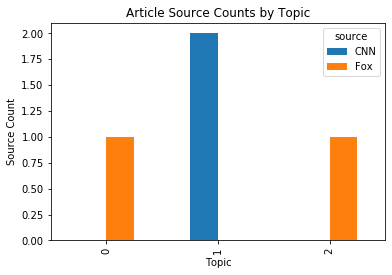

In [13]:
# Plot source counts for each topic
unstacked_topics.plot.bar(figsize=(6,4))
plt.title('Article Source Counts by Topic')
plt.xlabel('Topic')
plt.ylabel('Source Count')
plt.show()